# import library

In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
traindata = pd.read_csv("train.csv")
testdata = pd.read_csv("test.csv")
submissiondata = pd.read_csv("sample_submission.csv") 

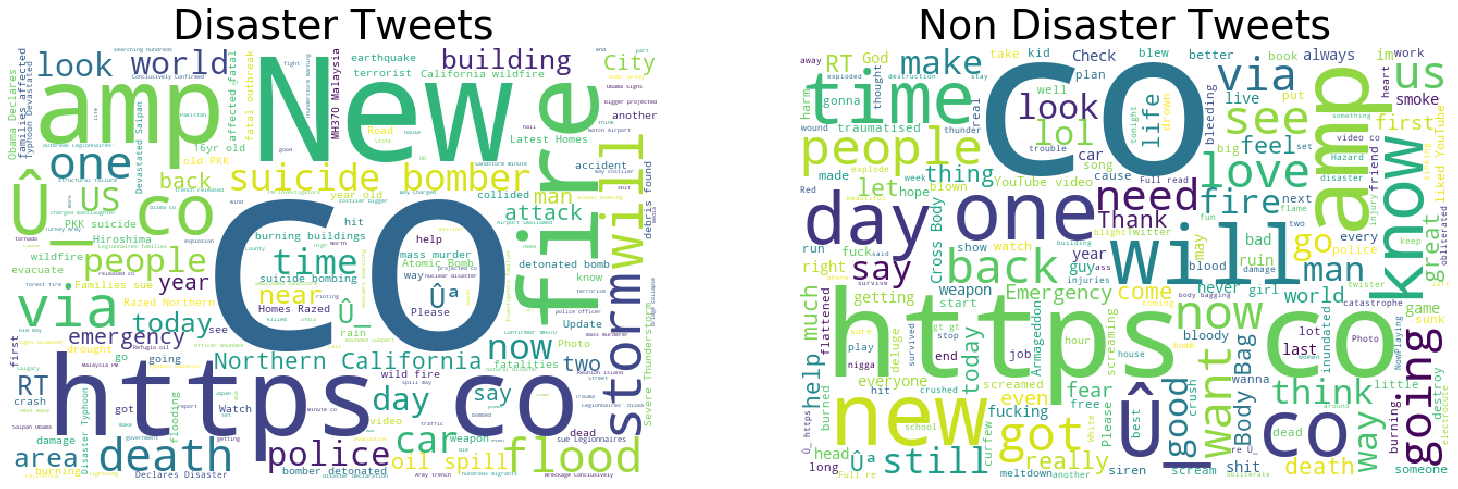

In [4]:
from wordcloud import WordCloud

disaster_tweets = traindata[traindata['target']==1]['text']
non_disaster_tweets = traindata[traindata['target']==0]['text']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(disaster_tweets))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Disaster Tweets',fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(non_disaster_tweets))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Non Disaster Tweets',fontsize=40);

In [5]:
# remove puctunations, https
def  clean_text(df, text_field):
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    return df
data_clean = clean_text(traindata, "text")
data_clean.head()

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this earthquake may allah forgive us all,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,13000 people receive wildfires evacuation orders in california,1
4,7,NaN,NaN,just got sent this photo from ruby alaska as smoke from wildfires pours into a school,1


In [6]:
#remove stopwords
stop = stopwords.words('english')
data_clean['text'] = data_clean['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
data_clean.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officers evacuation shelter place orders expected,1
3,6,NaN,NaN,13000 people receive wildfires evacuation orders california,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pours school,1


In [7]:
# lemmatizer
lemmatizer = WordNetLemmatizer()
def lemmatizer_(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

data_clean['text'] = data_clean['text'].apply(lambda x: lemmatizer_(x))

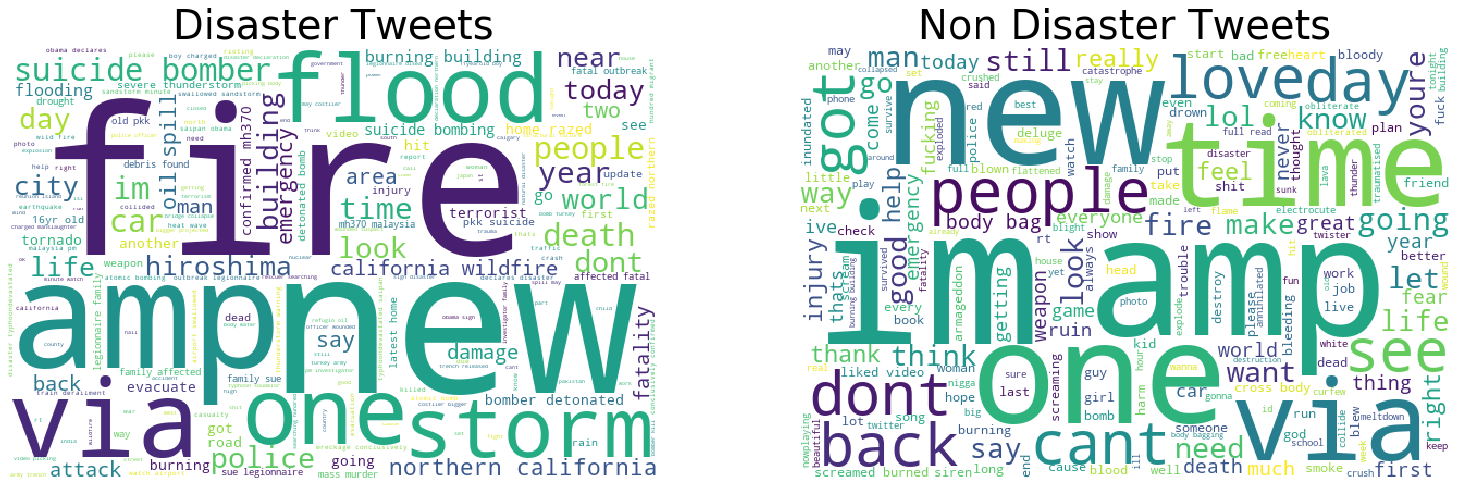

In [8]:
from wordcloud import WordCloud

disaster_tweets = data_clean[data_clean['target']==1]['text']
non_disaster_tweets = data_clean[data_clean['target']==0]['text']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(disaster_tweets))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Disaster Tweets',fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(non_disaster_tweets))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Non Disaster Tweets',fontsize=40);

In [9]:
new_stopwords = ['new','amp','one','via']
data_clean['text'] = data_clean['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (new_stopwords)]))

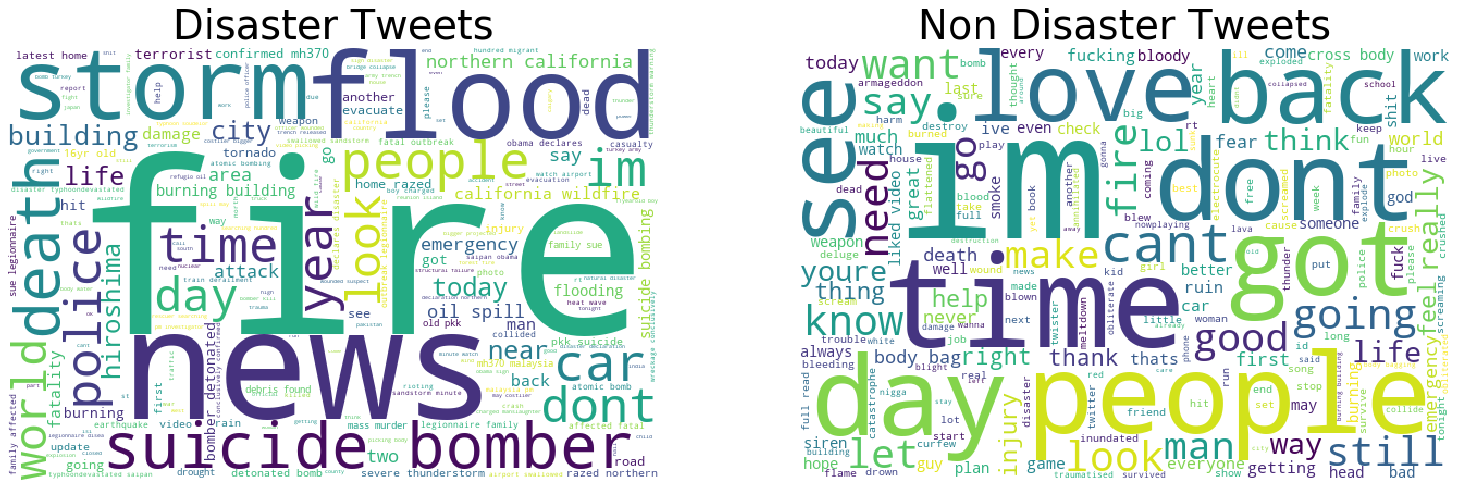

In [10]:
from wordcloud import WordCloud

disaster_tweets = data_clean[data_clean['target']==1]['text']
non_disaster_tweets = data_clean[data_clean['target']==0]['text']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(disaster_tweets))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Disaster Tweets',fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(non_disaster_tweets))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Non Disaster Tweets',fontsize=40);

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data_clean['text'],data_clean['target'],random_state = 0)

In [12]:
submission_test_clean = testdata.copy()
submission_test_clean = clean_text(submission_test_clean, "text")
submission_test_clean['text'] = submission_test_clean['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
submission_test_clean['text'] = submission_test_clean['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (new_stopwords)]))
submission_test_clean['text'] = submission_test_clean['text'].apply(lambda x: lemmatizer_(x))
submission_test_clean = submission_test_clean['text']
submission_test_clean.head()

0    happened terrible car crash                                  
1    heard earthquake different city stay safe everyone           
2    forest fire spot pond goose fleeing across street cannot save
3    apocalypse lighting spokane wildfire                         
4    typhoon soudelor kill 28 china taiwan                        
Name: text, dtype: object

# SGD classifier

In [13]:
# TfidfVectorizer and SGD classifier
pipeline_1 = Pipeline([
    ('tfidf',  TfidfVectorizer()),
    ('classifier', SGDClassifier()),
])
model1 = pipeline_1.fit(X_train, y_train)


y_predict1 = model1.predict(X_test)
print(classification_report(y_test, y_predict1))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1107
           1       0.77      0.72      0.75       797

    accuracy                           0.79      1904
   macro avg       0.79      0.78      0.79      1904
weighted avg       0.79      0.79      0.79      1904



In [14]:
# TfidfVectorizer and SGD classifier
submission_test_pred1 = model1.predict(submission_test_clean)

id_col = testdata['id']
submission_df_1 = pd.DataFrame({
                  "id": id_col, 
                  "target": submission_test_pred1})
#submission_df_1.head()

submission_df_1.to_csv('submission_1.csv', index=False)

In [15]:
# CountVectorizer and SGD classifier
pipeline_11 = Pipeline([
    ('countv',  CountVectorizer()),
    ('classifier', SGDClassifier()),
])
model11 = pipeline_11.fit(X_train, y_train)


y_predict11 = model11.predict(X_test)
print(classification_report(y_test, y_predict11))

              precision    recall  f1-score   support

           0       0.79      0.84      0.81      1107
           1       0.76      0.69      0.72       797

    accuracy                           0.78      1904
   macro avg       0.77      0.76      0.77      1904
weighted avg       0.77      0.78      0.77      1904



In [16]:
# CountVectorizer and SGD classifier
submission_test_pred11 = model11.predict(submission_test_clean)

id_col = testdata['id']
submission_df_11 = pd.DataFrame({
                  "id": id_col, 
                  "target": submission_test_pred11})
submission_df_11.head()

# CountVectorizer and SGD classifier
submission_df_11.to_csv('submission_11.csv', index=False)

# Naive Bayes classifier

In [17]:
# NB and TFIDF
pipeline_2 = Pipeline([
    
    ('tfidf', TfidfVectorizer()),  
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])
model2 = pipeline_2.fit(X_train, y_train)

y_predict2 = model2.predict(X_test)
print(classification_report(y_test, y_predict2))

              precision    recall  f1-score   support

           0       0.78      0.89      0.83      1107
           1       0.82      0.66      0.73       797

    accuracy                           0.79      1904
   macro avg       0.80      0.77      0.78      1904
weighted avg       0.80      0.79      0.79      1904



In [18]:
# NB and TFIDF
submission_test_pred2 = model2.predict(submission_test_clean)

id_col = testdata['id']
submission_df_2 = pd.DataFrame({
                  "id": id_col, 
                  "target": submission_test_pred2})
#submission_df_2.head()

submission_df_2.to_csv('submission_2.csv', index=False)

In [19]:
# NB and COUNT
pipeline_22 = Pipeline([
    
    ('countv', CountVectorizer()),  
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])
model22 = pipeline_22.fit(X_train, y_train)

y_predict22 = model22.predict(X_test)
print(classification_report(y_test, y_predict22))

              precision    recall  f1-score   support

           0       0.80      0.85      0.83      1107
           1       0.78      0.71      0.74       797

    accuracy                           0.79      1904
   macro avg       0.79      0.78      0.78      1904
weighted avg       0.79      0.79      0.79      1904



In [20]:
# NB and COUNT
submission_test_pred22 = model22.predict(submission_test_clean)

id_col = testdata['id']
submission_df_22 = pd.DataFrame({
                  "id": id_col, 
                  "target": submission_test_pred22})
#submission_df_2.head()

submission_df_22.to_csv('submission_22.csv', index=False)

# Logistic Regression classifier

In [21]:
#Logistic Regression and TFIDF
pipeline_3 = Pipeline([
    ('tfidf', TfidfVectorizer()),  # integer counts to weighted TF-IDF scores
    ('classifier', LogisticRegression()),  # train on TF-IDF vectors w/ LogisticRegression classifier
])
model3 = pipeline_3.fit(X_train, y_train)


y_predict3 = model3.predict(X_test)
print(classification_report(y_test, y_predict3))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84      1107
           1       0.83      0.67      0.74       797

    accuracy                           0.80      1904
   macro avg       0.81      0.79      0.79      1904
weighted avg       0.81      0.80      0.80      1904



In [22]:
#Logistic Regression and TFIDF
submission_test_pred3 = model3.predict(submission_test_clean)

id_col = testdata['id']
submission_df_3 = pd.DataFrame({
                  "id": id_col, 
                  "target": submission_test_pred3})
#submission_df_3.head()

submission_df_3.to_csv('submission_3.csv', index=False)

In [23]:
#Logistic Regression and CountV
pipeline_33 = Pipeline([
    ('tfidf', CountVectorizer()),  # integer counts to weighted TF-IDF scores
    ('classifier', LogisticRegression()),  # train on TF-IDF vectors w/ LogisticRegression classifier
])
model33 = pipeline_33.fit(X_train, y_train)

y_predict33 = model33.predict(X_test)
print(classification_report(y_test, y_predict33))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84      1107
           1       0.82      0.69      0.75       797

    accuracy                           0.80      1904
   macro avg       0.81      0.79      0.79      1904
weighted avg       0.81      0.80      0.80      1904



In [24]:
#Logistic Regression and CountV
submission_test_pred33 = model33.predict(submission_test_clean)

id_col = testdata['id']
submission_df_33 = pd.DataFrame({
                  "id": id_col, 
                  "target": submission_test_pred33})
#submission_df_33.head()

submission_df_33.to_csv('submission_33.csv', index=False)

# XGB classifier

In [25]:
#XGB classifier and TFIDF
pipeline_4 = Pipeline([
    ('tfidf', TfidfVectorizer()),  # integer counts to weighted TF-IDF scores
    ('classifier', XGBClassifier()),  # train on TF-IDF vectors w/ XGB classifier
])
model4 = pipeline_4.fit(X_train, y_train)

y_predict4 = model4.predict(X_test)
print(classification_report(y_test, y_predict4))

              precision    recall  f1-score   support

           0       0.76      0.92      0.83      1107
           1       0.84      0.60      0.70       797

    accuracy                           0.79      1904
   macro avg       0.80      0.76      0.77      1904
weighted avg       0.79      0.79      0.78      1904



In [26]:
#XGB classifier and TFIDF
submission_test_pred4 = model4.predict(submission_test_clean)

id_col = testdata['id']
submission_df_4 = pd.DataFrame({
                  "id": id_col, 
                  "target": submission_test_pred4})
#submission_df_4.head()

submission_df_4.to_csv('submission_4.csv', index=False)

In [27]:
#XGB classifier and CountV
pipeline_44 = Pipeline([
    ('countv', CountVectorizer()),  # integer counts to weighted TF-IDF scores
    ('classifier', XGBClassifier()),  # train on TF-IDF vectors w/ XGB classifier
])
model44 = pipeline_44.fit(X_train, y_train)

y_predict44 = model44.predict(X_test)
print(classification_report(y_test, y_predict44))

              precision    recall  f1-score   support

           0       0.77      0.92      0.84      1107
           1       0.84      0.62      0.72       797

    accuracy                           0.79      1904
   macro avg       0.81      0.77      0.78      1904
weighted avg       0.80      0.79      0.79      1904



In [28]:
#XGB classifier and CountV
submission_test_pred44 = model44.predict(submission_test_clean)

id_col = testdata['id']
submission_df_44 = pd.DataFrame({
                  "id": id_col, 
                  "target": submission_test_pred44})
#submission_df_44.head()

submission_df_44.to_csv('submission_44.csv', index=False)